<a href="https://colab.research.google.com/github/AlenaPotato/pet_projects/blob/main/client_segmentation/client_segmentation_rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

!pip install kmodes
from kmodes.kmodes import KModes
from sklearn import preprocessing

Mounted at /content/drive/


Есть данные результатов анкетирования пользователей сервиса доставки. Необходимо провести кластерный анализ аудитории сервиса и для каждого выявленного кластера сформулировать бизнес-портрет клиентов.

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Датасеты/data.xlsx')

# Удалю ненужные колонки
df = df.drop('client_id', axis=1)

In [ ]:
# Поскольку я буду тестировать несколько моделей и часть кода мне нужно будет переиспользовать,
# то создам кастомную функцию для этих нужд

def find_cluster(model_kind, df, clusters_num):
  '''
  Функция будет искать оптимальное количество кластеров с помощью метода локтя.

  Оптимальное количество кластеров определяется точкой на графике, где начинается
  постепенное выравнивание кривой. Эта точка напоминает "локоть" на графике и
  называется "точкой локтя".'''

  # Определение оптимального количества кластеров методом локтя
  wcss = []
  if model_kind == 'kmeans':
    for i in range(1, clusters_num+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)

  if model_kind == 'kmodes':
    for i in range(1, clusters_num+1):
        kmode = KModes(n_clusters=i, init = "random", n_init = 5, verbose=1)
        kmode.fit(df)
        wcss.append(kmode.cost_)


  # Построение графика
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, clusters_num+1), wcss)
  plt.title(f'Метод локтя для модели {model_kind}')
  plt.xlabel('Количество кластеров')
  plt.ylabel('WCSS')
  plt.show()


# Определение значимых признаков
def get_top_features_for_cluster(cluster, n):
    cluster_centroid = centroid_df.iloc[cluster]
    important_features = cluster_centroid.abs().sort_values(ascending=False)[:n]
    return important_features


## Классика k-means

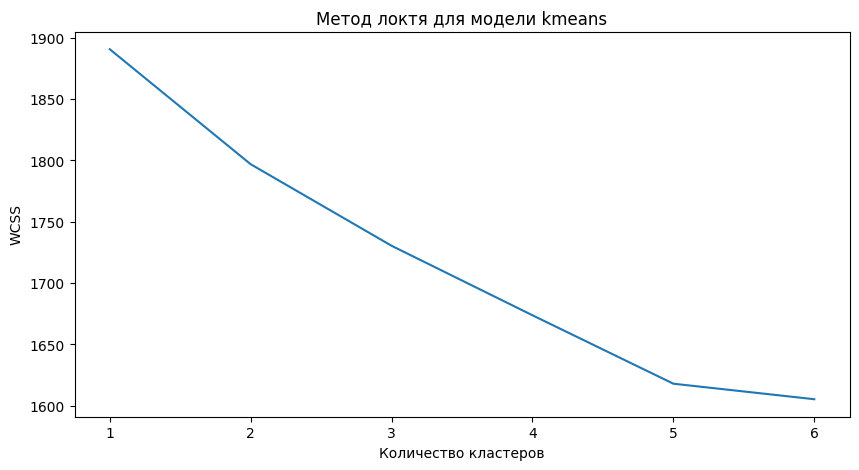

In [ ]:
# Считывание данных
df_km = df.copy()

# Преобразование категориальных данных в числовые
df_km = pd.get_dummies(df_km, drop_first=True)

find_cluster('kmeans', df_km, 6)

Метод локтя предлагает 2 или 5 кластеров. Поскольку на отметке 5 "локоть" сгибается сильнее, то построю модель для 5ти кластеров.

In [ ]:
# Обучение модели K-means
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_km['cluster'] = kmeans.fit_predict(df_km)

# Определение наиболее значимых признаков
# Центроиды кластеров
centroids = kmeans.cluster_centers_

# Преобразование центроидов в DataFrame
centroid_df = pd.DataFrame(centroids, columns=df_km.columns[:-1])

# Получение топ-5 фичей для кластеров
for i in range(5):
  print(f'Кластер № {i}')
  print(get_top_features_for_cluster(i, 5))
  print('\n')



Кластер № 0
LifeStyle_Работаю по гибридному или смешанному графику                                                  0.904762
TheMostImportantFoodFeature_Вкус                                                                        0.714286
Statement_У_меня_напряженное_расписание,_поэтому_я_плачу_за_услуги,_которые_помогают_экономить_время    0.642857
Age_25 - 34 лет                                                                                         0.595238
ReasonYouBuyOurProduct_Не_нравится_готовить                                                             0.571429
Name: 0, dtype: float64


Кластер № 1
LifeStyle_Работаю из дома                                                      0.950000
ReasonYouBuyOurProduct_Это_выгодно_для_бюджета                                 0.766667
TheMostImportantFoodFeature_Вкус                                               0.733333
ReasonYouBuyOurProduct_Не_нравится_готовить                                    0.650000
Statement_Я_часто_покупаю_продукт

**Кластер 0:**  Этот кластер включает в себя молодых профессионалов, работающих по гибкому графику, которые ценят вкусные блюда и готовы платить за удобства, экономящие их время. Они не любят готовить и предпочитают готовую еду или полуфабрикаты.

**Кластер 1:** Домашние работники, которые ориентированы на экономию и предпочитают выгодные предложения, не жертвуя при этом вкусом. Они также не любят готовить и ищут простые решения для питания, часто покупая продукты по скидкам.

**Кластер 2:** Этот кластер состоит из офисных работников, которые стремятся к экономии и активно ищут доступные по цене, но качественные продукты. Они часто обращают внимание на скидки и выбирают полезные варианты еды.

**Кластер 3:** Молодые мужчины, работающие в офисе, которые ценят вкусные блюда и часто берут еду с собой на работу. Они предпочитают готовые решения, которые можно быстро и удобно употребить в течение рабочего дня.

**Кластер 4:** Этот кластер включает в себя взрослых людей в возрасте 35-44 лет, преимущественно из семей с детьми. Они ценят вкусные и полезные блюда, а также активно интересуются чтением книг.



Такой подход хоть и является классическим и интуитивно понятным, но не совсем корректным. Можно было заметить, что в датасете используются только категориальные переменные,<a href="https://www.geeksforgeeks.org/k-mode-clustering-in-python/ "> а для такого случая лучше использовать пакет kmodes</a>.


## kmodes через one-hot encoding

In [ ]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum, drop_first=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 2771.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 2771.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 2771.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 2771.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 2771.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 70, cost: 2565.0
Run 1, iteration: 2/100, moves: 21, cost: 2565.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 52, cost: 2590.0
Run 2, iteration: 2/100, moves:

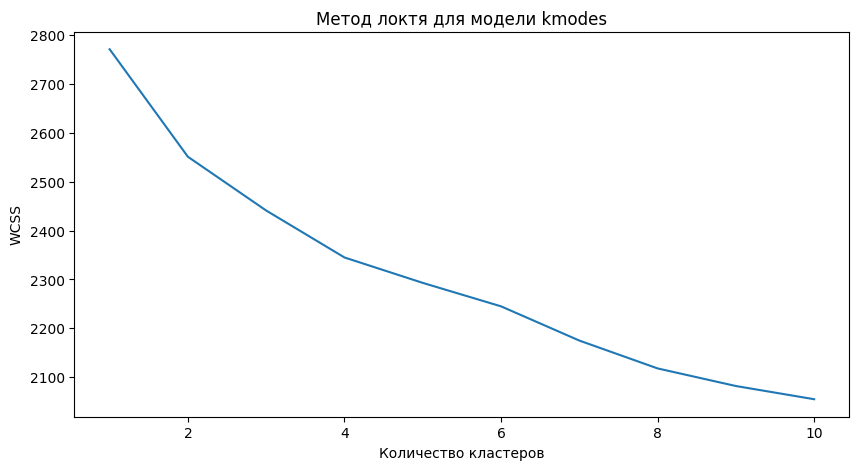

In [ ]:
find_cluster('kmodes', df_dum, 10)

"Локоть" полностью сгибается на значении 9. Но для оптимальности выберу 4 кластера - изгиб на значении 4 весомый.

In [ ]:
# Обучение модели
kmode = KModes(n_clusters=4, init = "random", n_init = 5, verbose=1)
df_dum['cluster'] = kmode.fit_predict(df_dum)

# Определение наиболее значимых признаков
# Центроиды кластеров
centroids = kmeans.cluster_centers_

# Преобразование центроидов в DataFrame
centroid_df = pd.DataFrame(centroids, columns=df_km.columns[:-1])

# Получение топ-4 фичей для кластеров
for i in range(4):
  print(f'Кластер № {i}')
  print(get_top_features_for_cluster(i, 4))
  print('\n')


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 91, cost: 2490.0
Run 1, iteration: 2/100, moves: 40, cost: 2474.0
Run 1, iteration: 3/100, moves: 5, cost: 2474.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 54, cost: 2464.0
Run 2, iteration: 2/100, moves: 22, cost: 2464.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 90, cost: 2434.0
Run 3, iteration: 2/100, moves: 35, cost: 2411.0
Run 3, iteration: 3/100, moves: 10, cost: 2411.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 81, cost: 2361.0
Run 4, iteration: 2/100, moves: 32, cost: 2352.0
Run 4, iteration: 3/100, moves: 9, cost: 2351.0
Run 4, iteration: 4/100, moves: 1, cost: 2351.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteratio

**Кластер 0:** Молодые профессионалы, работающие по гибридному графику, которые ценят вкусные блюда и готовы платить за удобства, которые помогают экономить время.

**Кластер 1:** Домашние работники, которые ориентированы на экономию и предпочитают выгодные предложения, не жертвуя при этом вкусом еды. Они также не любят готовить и предпочитают готовые решения.

**Кластер 2:**  Сотрудники офисов и предприятий, которые ценят доступные по цене продукты и активно ищут выгодные предложения и скидки.

**Кластер 3:** Молодые офисные работники, которые ценят вкусные блюда и часто берут еду с собой на работу, чтобы питаться в течение дня.

## Через label

Рассмотрим альтернатиыный вариант кодирования признаков.

In [ ]:
df_lab = df.copy()

In [ ]:
# Поскольку в датасете несколько столбцов уже представленны в виде даммт-переменных, раскодирую их обратно в значения
def split_columns(df, start, end, col_name:str):
  '''
  Функция берёт контретный срез по столбцам, каждый столбец сплитует, часть значения столбца записывает вместо 1.
  '''
  df[col_name] = ''
  for col in df.columns[start:end]:
    df.loc[df[col] == 1, col_name] = ' '.join(col.split('_')[1:])

# Эксперно определяю сплиты
splits = [[6,12], [12,19], [19, 25], [25, df.shape[1]+1]]
new_cols = ['TheMostImportantFoodFeature', 'ReasonYouBuyOurProduct', 'Statement', 'InterestedIn']
for i in range(len(splits)):
  split = splits[i]
  col_name = new_cols[i]
  start, end = split[0], split[1]
  split_columns(df_lab, start, end, col_name)

df_lab.drop(columns=df_lab.columns[6:38], inplace=True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 1344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 1344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 1344.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 1344.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 63, cost: 1170.0
Run 1, iteration: 2/100, moves: 9, cost: 1170.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 46, cost: 1171.0
Run 2, iteration: 2/100, moves: 

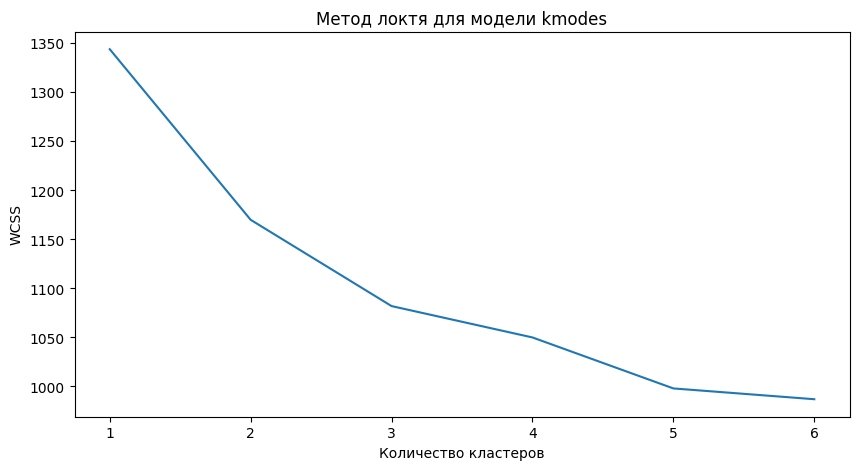

In [ ]:
le = preprocessing.LabelEncoder()
new_df = df_lab.apply(le.fit_transform)

find_cluster('kmodes', new_df, 6)

In [ ]:
# Обучение модели K-means
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
new_df['cluster'] = kmode.fit_predict(new_df)

# Определение наиболее значимых признаков
# Центроиды кластеров
centroids = kmeans.cluster_centers_

# Преобразование центроидов в DataFrame
centroid_df = pd.DataFrame(centroids, columns=df_km.columns[:-1])

# Получение топ-3 фичей для кластеров
for i in range(3):
  print(f'Кластер № {i}')
  print(get_top_features_for_cluster(i, 3))
  print('\n')

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 57, cost: 1127.0
Run 1, iteration: 2/100, moves: 6, cost: 1127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 71, cost: 1108.0
Run 2, iteration: 2/100, moves: 1, cost: 1108.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 62, cost: 1108.0
Run 3, iteration: 2/100, moves: 37, cost: 1086.0
Run 3, iteration: 3/100, moves: 5, cost: 1086.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 60, cost: 1110.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 62, cost: 1084.0
Run 5, iteration: 2/100, moves: 25, cost: 1084.0
Best run was number 5
Кластер № 0
LifeStyle_Работаю по гибридному или смешанному графику                         

**Кластер 0:** Этот кластер можно охарактеризовать как занятых профессионалов с гибким графиком работы, которые ценят вкусные блюда и готовы платить за удобства, чтобы сэкономить время.

**Кластер 1:** Этот кластер состоит из людей, работающих удаленно, которые ориентированы на экономию и предпочитают выгодные предложения, не жертвуя при этом вкусом продуктов.

**Кластер 2:** Этот кластер представляет сотрудников предприятий и офисов, которые ценят экономичные и доступные по цене варианты питания, уделяя основное внимание стоимости продуктов.


## Вывод

Кластеризация позволяет сегментировать аудиторию и понимать основные характеристики каждой группы, что полезно для таргетированного маркетинга и персонализации предложений. Анализ важности признаков помогает более точно определить ключевые характеристики клиентов в каждом кластере.

При построении кластеров нужно учитывать типы данных: если датасет состоит только из категориальных переменных, то лучше использовать модель kmodes, при этом можно использовать два варианта кодирования переменных: one-hot-encoding и label-encoding.